In [2]:
#this program will do the photometry on the reference frame to get stars 
#for the subtraction and to get stars for later

#if you use this code, please cite Oelkers & Stassun 2018

#import the relevant libraries for basic tools
import numpy as np
import scipy
from scipy import stats
import scipy.ndimage as ndimage
import astropy
from astropy.stats import sigma_clipped_stats
import math
import time
from photutils import DAOStarFinder
from photutils import aperture_photometry
from photutils import CircularAperture
from photutils import CircularAnnulus

#for reading in fits files
from astropy.io import fits
from astropy.wcs import WCS

#import relevant libraries for a list
import glob, os
from os import listdir
from os.path import isfile, join, exists
%matplotlib inline                           
%config InlineBackend.figure_format='retina'      
from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pylab as plt                     
plt.rcParams['figure.figsize'] = (14.0, 14.0)    

## Here I only study one skygroup

In [3]:
###BEGIN UPDATE#####
skygroup = 1
#useful directories
cdedir = '/home/usuario/dia_kepler/mychanges/Python/' #code directory
caldir = '/home/usuario/Documents/Mestrado/FFIs/allffi_cut/clean/masters/season0/' # directory to output the flux files and location of master frame
clndir = '/home/usuario/Documents/Mestrado/FFIs/allffi_cut/clean/'#directory with the cleaned images
##END UPDATE####

#read in the master frame
mast, mheader = fits.getdata(caldir+str(skygroup)+'.fits', header = True)

In [5]:
# import pandas as pd
# file = "/home/usuario/Documents/Mestrado/FFIs/allffi_cut/clean/masters/kic_ct_join_12142009.txt"
# kic = pd.read_csv(file,sep='|',header=[0])

In [7]:
# kic2 = kic.loc[:,['kic_kepler_id','kic_ra','kic_degree_ra','kic_dec','kic_kepmag','kct_sky_group_id_value','kct_num_season_onCCD','kic_variable','kic_umag', 'kic_gmag', 'kic_rmag', 'kic_imag', 'kic_zmag','kic_gredmag','kic_d51mag', 'kic_jmag', 'kic_hmag', 'kic_kmag']]
kic2 = kic.loc[:,['kic_kepler_id','kic_ra','kic_degree_ra','kic_dec','kic_kepmag','kct_sky_group_id_value','kct_num_season_onCCD','kic_variable','kic_galaxy','kct_module_season_0_value','kct_module_season_1_value','kct_module_season_2_value','kct_module_season_3_value','kct_output_season_0_value','kct_output_season_1_value', 'kct_output_season_2_value','kct_output_season_3_value']]
# kic2.to_csv("/home/usuario/Documents/Mestrado/FFIs/allffi_cut/clean/masters/kic_cut.csv")

In [8]:
'''kic.columns = 'kic_kepler_id', 'kic_ra', 'kic_dec', 'kic_pmra', 'kic_pmdec',
       'kic_umag', 'kic_gmag', 'kic_rmag', 'kic_imag', 'kic_zmag',
       'kic_gredmag', 'kic_d51mag', 'kic_jmag', 'kic_hmag', 'kic_kmag',
       'kic_kepmag', 'kic_tmid', 'kic_scpid', 'kic_altid', 'kic_altsource',
       'kic_galaxy', 'kic_blend', 'kic_variable', 'kic_teff', 'kic_logg',
       'kic_feh', 'kic_ebminusv', 'kic_av', 'kic_radius', 'kic_cq', 'kic_pq',
       'kic_aq', 'kic_catkey', 'kic_scpkey', 'kic_parallax', 'kic_glon',
       'kic_glat', 'kic_pmtotal', 'kic_grcolor', 'kic_jkcolor', 'kic_gkcolor',
       'kic_degree_ra', 'kic_tm_designation', 'kct_sky_group_id_value',
       'kct_crowding_value', 'kct_channel_season_0_value',
       'kct_channel_season_1_value', 'kct_channel_season_2_value',
       'kct_channel_season_3_value', 'kct_column_season_0_value',
       'kct_column_season_1_value', 'kct_column_season_2_value',
       'kct_column_season_3_value', 'kct_module_season_0_value',
       'kct_module_season_1_value', 'kct_module_season_2_value',
       'kct_module_season_3_value', 'kct_output_season_0_value',
       'kct_output_season_1_value', 'kct_output_season_2_value',
       'kct_output_season_3_value', 'kct_row_season_0_value',
       'kct_row_season_1_value', 'kct_row_season_2_value',
       'kct_row_season_3_value', 'kct_ktc_flag', 'kct_distance_0',
       'kct_distance_1', 'kct_distance_2', 'kct_distance_3',
       'kct_num_season_onCCD', 'kct_contamination'],
      dtype='object' '''

"kic.columns = 'kic_kepler_id', 'kic_ra', 'kic_dec', 'kic_pmra', 'kic_pmdec',\n       'kic_umag', 'kic_gmag', 'kic_rmag', 'kic_imag', 'kic_zmag',\n       'kic_gredmag', 'kic_d51mag', 'kic_jmag', 'kic_hmag', 'kic_kmag',\n       'kic_kepmag', 'kic_tmid', 'kic_scpid', 'kic_altid', 'kic_altsource',\n       'kic_galaxy', 'kic_blend', 'kic_variable', 'kic_teff', 'kic_logg',\n       'kic_feh', 'kic_ebminusv', 'kic_av', 'kic_radius', 'kic_cq', 'kic_pq',\n       'kic_aq', 'kic_catkey', 'kic_scpkey', 'kic_parallax', 'kic_glon',\n       'kic_glat', 'kic_pmtotal', 'kic_grcolor', 'kic_jkcolor', 'kic_gkcolor',\n       'kic_degree_ra', 'kic_tm_designation', 'kct_sky_group_id_value',\n       'kct_crowding_value', 'kct_channel_season_0_value',\n       'kct_channel_season_1_value', 'kct_channel_season_2_value',\n       'kct_channel_season_3_value', 'kct_column_season_0_value',\n       'kct_column_season_1_value', 'kct_column_season_2_value',\n       'kct_column_season_3_value', 'kct_module_season_0_valu

## Here I upload all the data without differentiating between skygroups and seasons

In [9]:
#usar esse e nao os outros

import pandas as pd
file = "/home/usuario/Documents/Mestrado/FFIs/allffi_cut/clean/masters/kic_cut.csv"
kic2 = pd.read_csv(file,sep=',',header=[0])

In [10]:
kic2

,Unnamed: 0,kic_kepler_id,kic_ra,kic_degree_ra,kic_dec,kic_kepmag,kct_sky_group_id_value,kct_num_season_onCCD,kic_variable,kct_distance_0,...,kic_umag,kic_gmag,kic_rmag,kic_imag,kic_zmag,kic_gredmag,kic_d51mag,kic_jmag,kic_hmag,kic_kmag
0,0,482249,19.388891,290.83337,36.397827,18.181000,84.0,0,0,NaN,...,NaN,19.009001,18.174000,17.823999,NaN,NaN,NaN,16.245001,15.734000,15.259000
1,1,482258,19.389015,290.83524,36.398258,19.591999,84.0,0,0,NaN,...,NaN,20.358000,19.580000,19.260000,NaN,NaN,NaN,NaN,NaN,NaN
2,2,482260,19.389038,290.83557,36.394833,17.438999,84.0,0,0,NaN,...,NaN,18.509001,17.320000,16.469999,NaN,NaN,NaN,15.827000,15.271000,14.898000
3,3,482262,19.389044,290.83563,36.399788,19.788000,84.0,0,0,NaN,...,NaN,20.212999,19.737000,19.601000,NaN,NaN,NaN,NaN,NaN,NaN
4,4,482264,19.389071,290.83603,36.396782,19.632000,84.0,0,0,NaN,...,NaN,20.153000,19.591000,19.403000,NaN,NaN,NaN,NaN,NaN,NaN
5,5,482267,19.389206,290.83807,36.393600,17.978001,84.0,0,0,NaN,...,NaN,18.542999,17.926001,17.736000,17.621000,NaN,18.285000,16.785000,15.699000,15.528000
6,6,482292,19.389481,290.84222,36.391834,19.787001,84.0,0,0,NaN,...,NaN,20.561001,19.766001,19.457001,NaN,NaN,NaN,NaN,NaN,NaN
7,7,482296,19.389601,290.84402,36.397099,17.117001,84.0,0,0,NaN,...,NaN,17.663000,17.112000,16.882999,16.806999,NaN,17.441999,15.592000,15.448000,15.057000
8,8,482297,19.389610,290.84415,36.394718,17.912001,84.0,0,0,NaN,...,NaN,18.476000,17.832001,17.670000,17.653000,NaN,18.228001,16.601999,16.292000,15.980000
9,9,482308,19.389790,290.84686,36.385712,18.966999,84.0,0,0,NaN,...,NaN,19.812000,18.962999,18.601000,NaN,NaN,NaN,16.773001,15.902000,15.795000


In [11]:
kic_sem_mag = kic2[(kic2.kic_kepmag.isna()) & (kic2.kct_num_season_onCCD!=0)]
kic_com_mag = kic2[(kic2.kic_kepmag.notna()) & (kic2.kct_num_season_onCCD!=0)]
kic_visto = kic2[(kic2.kct_num_season_onCCD!=0)]
len(kic_visto)

4451462

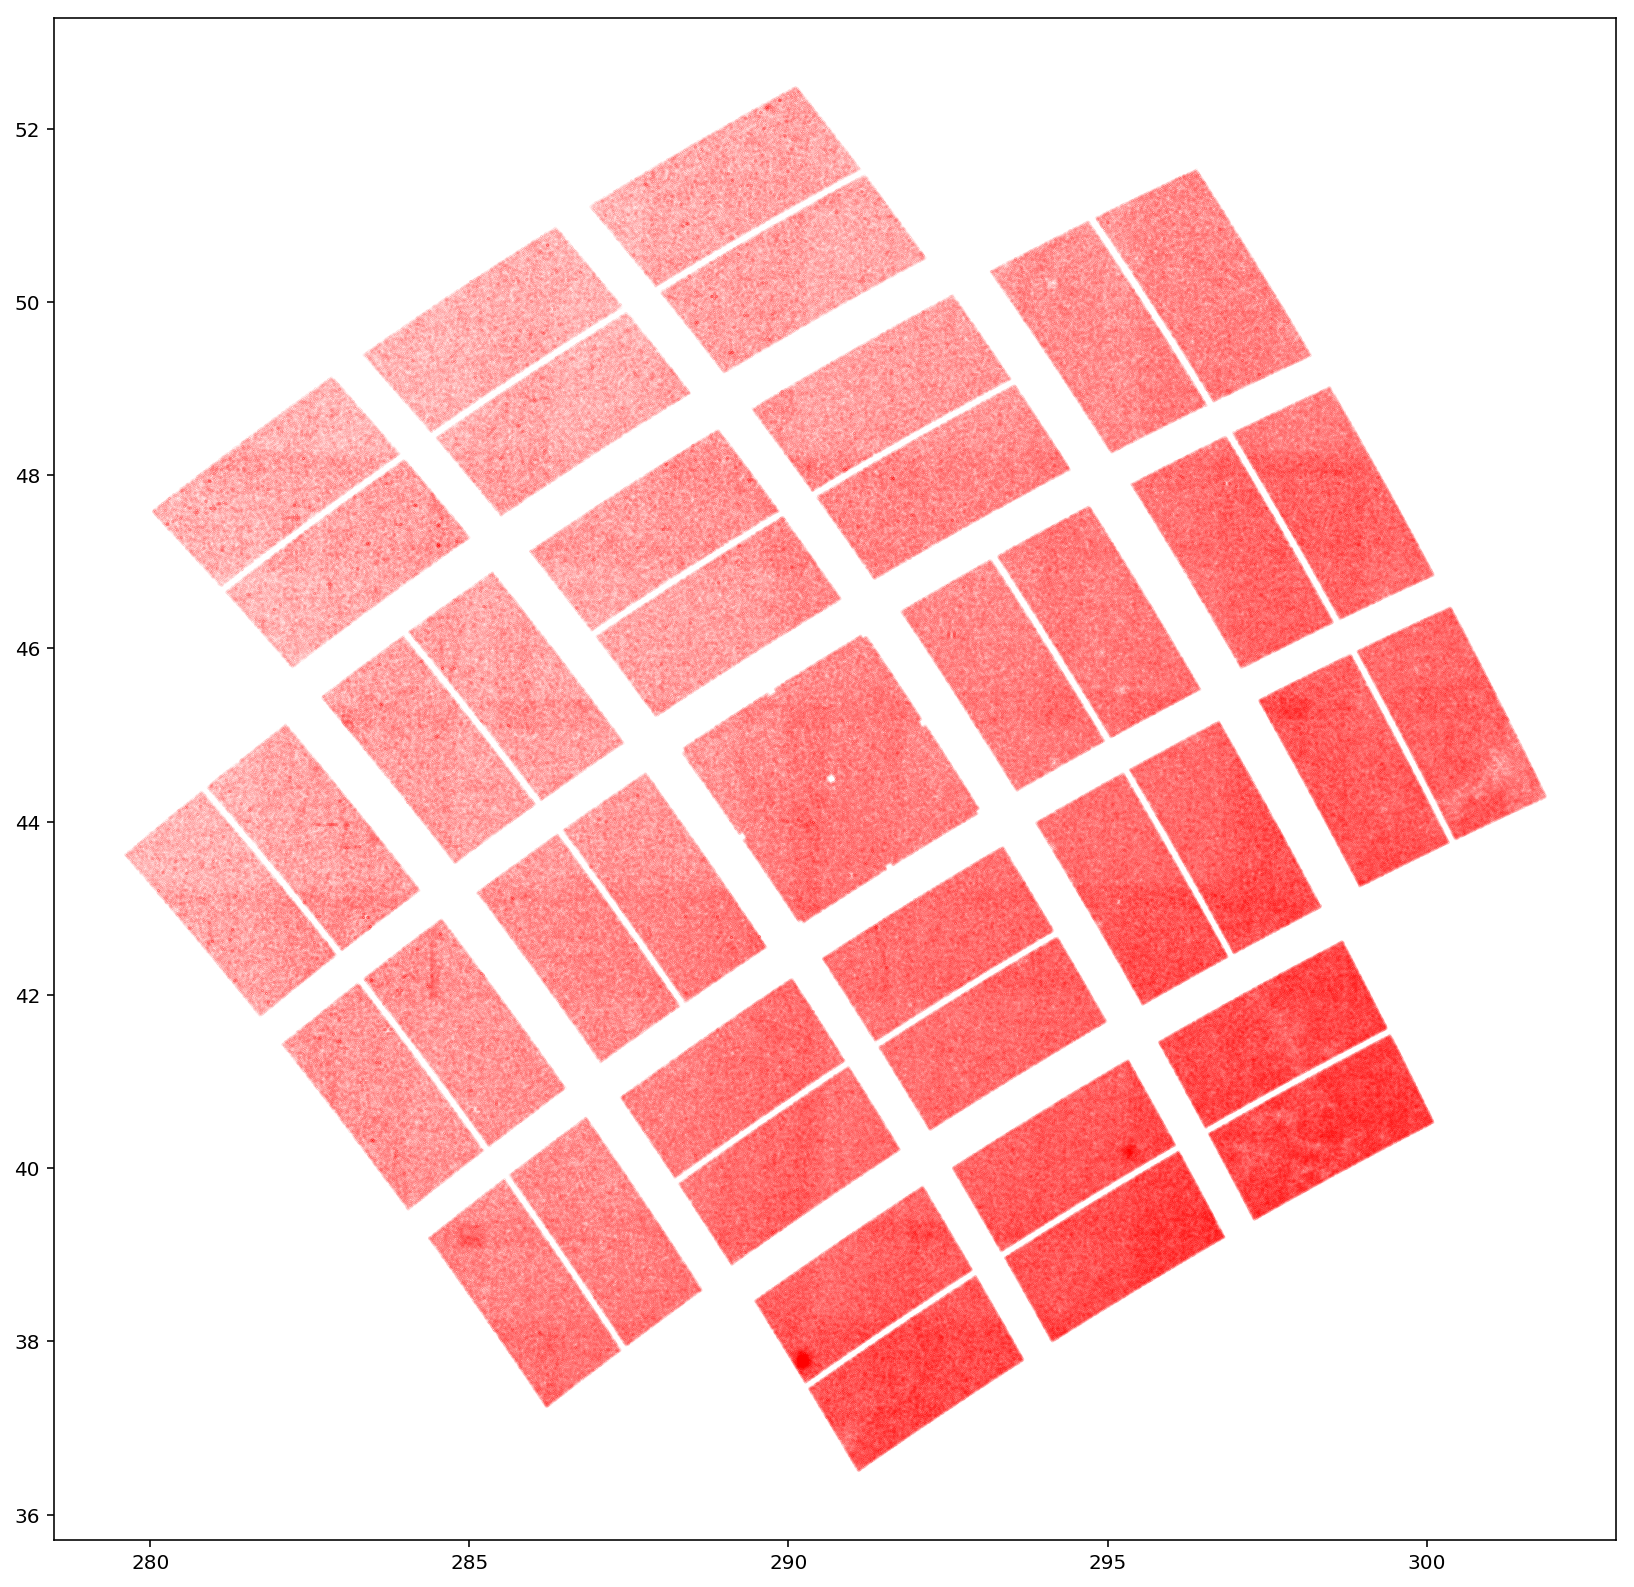

In [12]:
import matplotlib.pyplot as plt
plt.plot(kic_visto.kic_degree_ra,kic_visto.kic_dec, 'ro', markersize=0.01, fillstyle='none')
plt.show()

## Here I define a cut for a specific skygroup

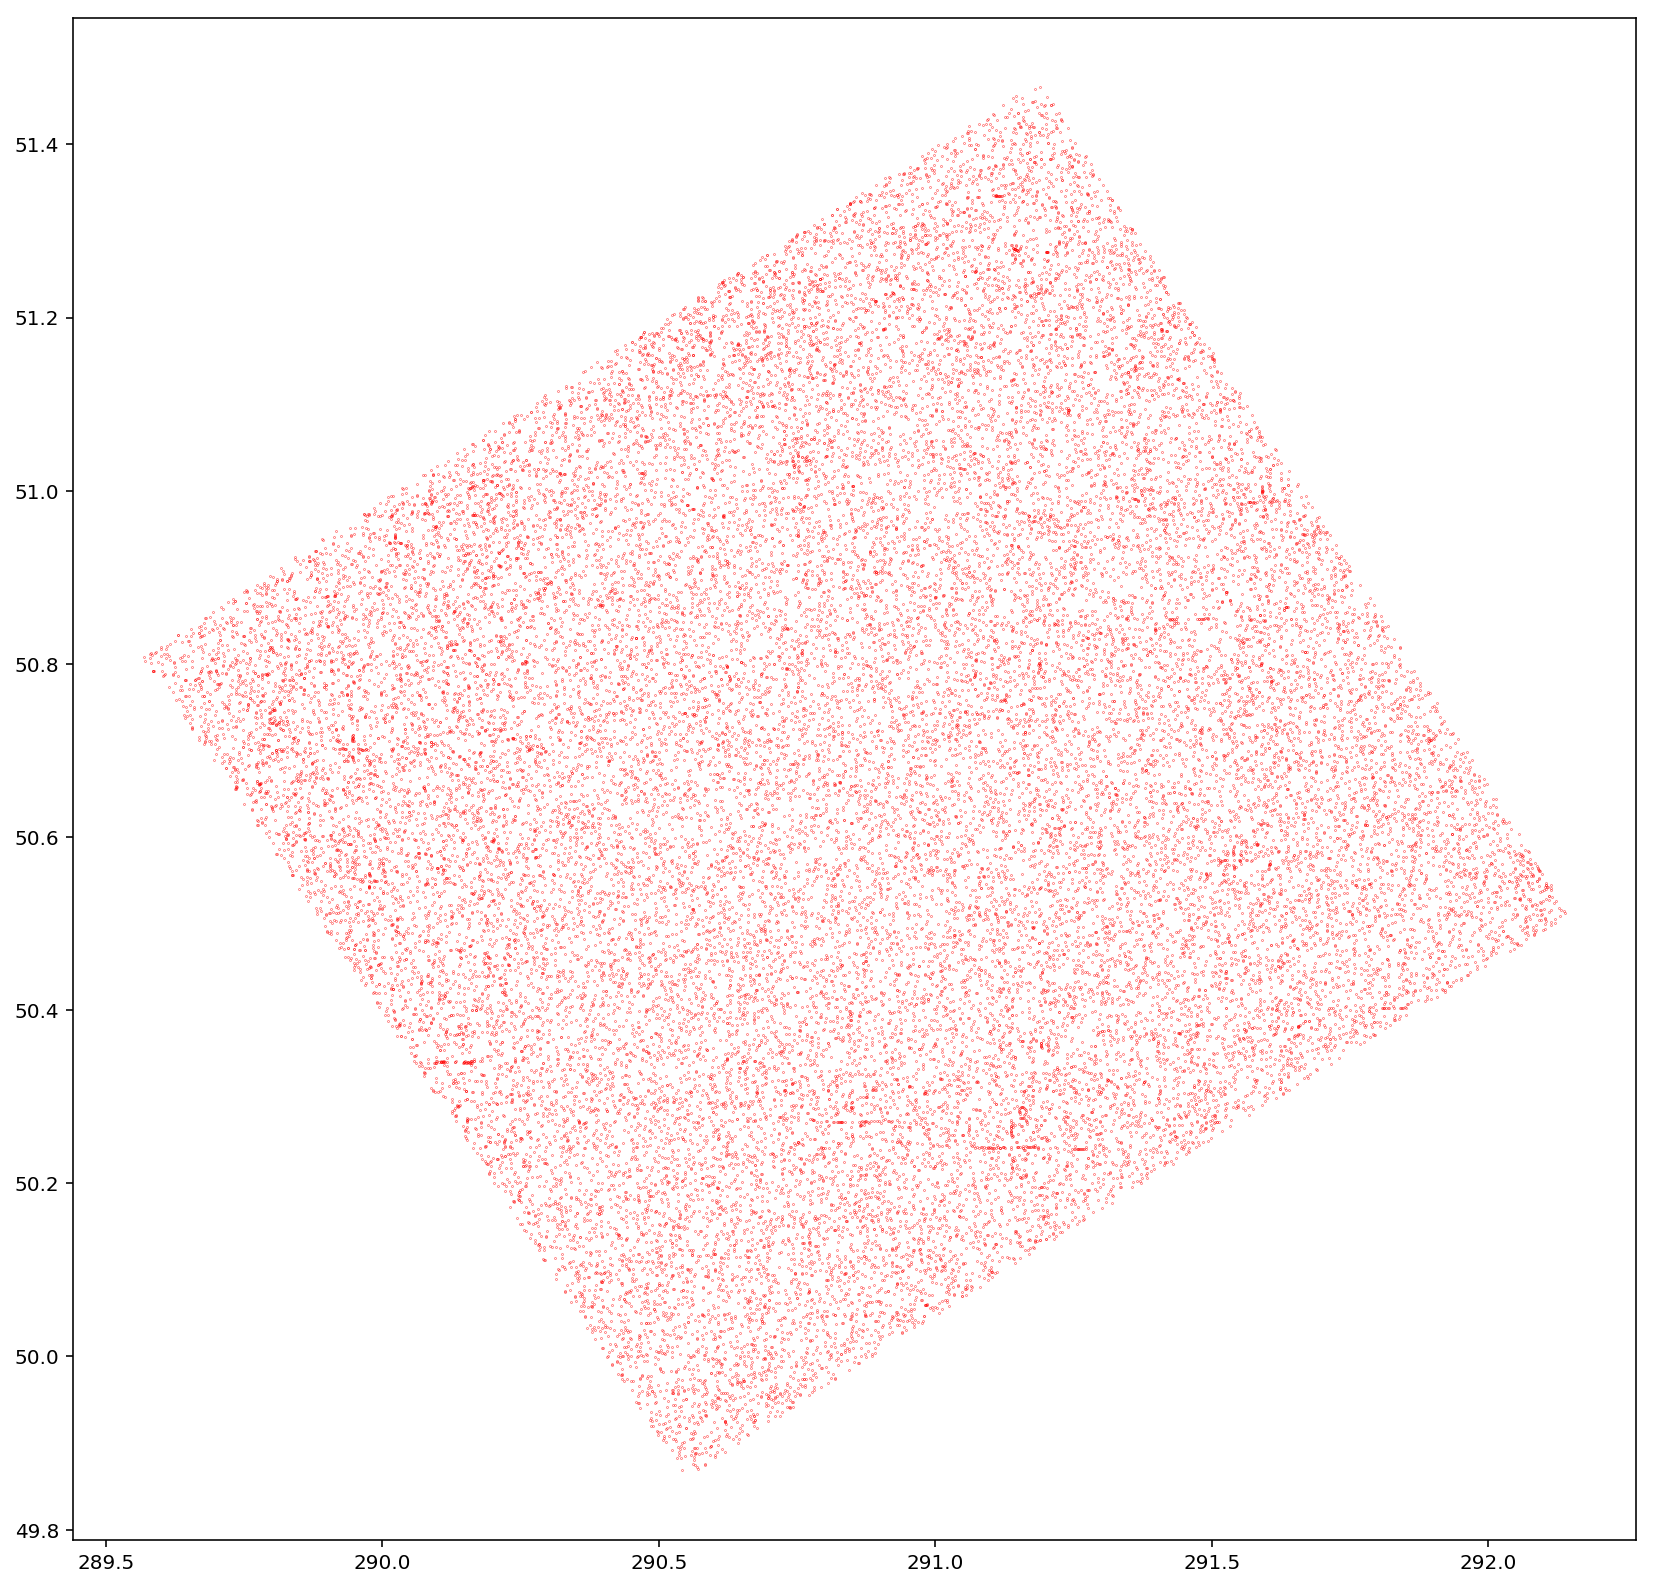

In [13]:
kic_visto_1 = kic_visto[(kic_visto.kct_sky_group_id_value==1)]
plt.plot(kic_visto_1.kic_degree_ra,kic_visto_1.kic_dec, 'ro', markersize=0.2, fillstyle='none')
plt.show()

In [14]:
kic_visto_1

,Unnamed: 0,kic_kepler_id,kic_ra,kic_degree_ra,kic_dec,kic_kepmag,kct_sky_group_id_value,kct_num_season_onCCD,kic_variable,kct_distance_0,...,kic_umag,kic_gmag,kic_rmag,kic_imag,kic_zmag,kic_gredmag,kic_d51mag,kic_jmag,kic_hmag,kic_kmag
6173046,6173046,11710437,19.368284,290.52426,49.892181,17.091999,1.0,4,0,9.0,...,NaN,17.806999,17.004000,16.785000,16.455000,NaN,17.533001,15.542000,15.289000,14.880000
6173058,6173058,11710449,19.368917,290.53375,49.882557,18.825001,1.0,4,0,9.0,...,NaN,18.579000,18.757999,18.910000,NaN,NaN,NaN,NaN,NaN,NaN
6173059,6173059,11710450,19.368963,290.53445,49.895321,17.538000,1.0,4,0,15.0,...,NaN,NaN,17.489000,17.348000,17.188999,NaN,17.778000,16.422001,15.682000,16.858999
6173063,6173063,11710454,19.369066,290.53598,49.889660,17.195999,1.0,4,0,13.0,...,NaN,17.691999,17.132999,16.983999,16.997000,NaN,17.469999,15.862000,15.567000,15.224000
6173064,6173064,11710455,19.369143,290.53714,49.886436,17.694000,1.0,4,0,12.0,...,NaN,18.750000,17.684000,17.232000,NaN,NaN,NaN,15.325000,14.742000,14.699000
6173066,6173066,11710457,19.369242,290.53864,49.893162,17.563000,1.0,4,0,16.0,...,NaN,NaN,17.517000,17.292999,17.285000,NaN,17.934999,16.336000,15.656000,15.180000
6173070,6173070,11710461,19.369385,290.54077,49.883270,18.042999,1.0,4,0,12.0,...,NaN,18.728001,18.018000,17.737000,NaN,NaN,NaN,NaN,NaN,NaN
6173071,6173071,11710462,19.369392,290.54089,49.896439,12.502000,1.0,4,0,19.0,...,NaN,12.575000,12.477000,12.509000,12.569000,NaN,12.505000,11.814000,11.631000,11.617000
6173074,6173074,11710465,19.369434,290.54150,49.868408,15.470000,1.0,4,0,3.0,...,NaN,15.733000,15.416000,15.357000,15.396000,NaN,15.572000,14.593000,14.311000,14.323000
6173081,6173081,11710472,19.369770,290.54657,49.894138,18.179001,1.0,4,0,21.0,...,NaN,19.204000,18.170000,17.729000,NaN,NaN,NaN,16.270000,15.573000,15.121000


In [15]:
def coord_min(x,y,xs,ys):
    array=[]
    sigmax = np.std(xs)
    sigmay = np.std(ys)
    for i in range(len(xs)):
        if abs(x - xs[i])<sigmax and abs(y - ys[i])<sigmay:
            array.append([xs[i],ys[i]])
    return array

In [16]:
a = np.array(kic_visto.kic_degree_ra)
b = np.array(kic_visto.kic_dec)
coord_min(282.06316,44.358425,a,b)

[[282.8493, 40.699501],
 [282.86609, 40.698177],
 [282.88263, 40.698204],
 [282.88428, 40.69812],
 [282.90161, 40.698498],
 [282.92136, 40.698418],
 [282.9291100000001, 40.698399],
 [282.93848, 40.698299],
 [282.94809, 40.698448],
 [282.9534, 40.699509],
 [282.96127, 40.699806],
 [282.96658, 40.69899],
 [283.0191, 40.698318],
 [283.03149, 40.698154],
 [283.06302, 40.699921],
 [283.0925, 40.69796],
 [283.14935, 40.697971],
 [283.1824, 40.69891],
 [283.18958, 40.699074],
 [283.23853, 40.699329],
 [283.2476200000001, 40.698528],
 [283.28625, 40.699837],
 [283.2897, 40.698174],
 [283.29974, 40.698402],
 [283.30603, 40.699306],
 [283.46359, 40.69965],
 [283.4693, 40.698193],
 [283.48923, 40.699341],
 [283.4944799999999, 40.69978],
 [283.52609, 40.699081],
 [283.5438200000001, 40.698692],
 [283.55658, 40.698326],
 [283.58453, 40.699429],
 [283.58551, 40.69821500000001],
 [283.58987, 40.699039],
 [283.59644, 40.698872],
 [283.60239, 40.699329],
 [283.60852, 40.698132],
 [283.63095, 40.698071]

In [73]:
c=[]
for i in range(len(a)):
    
    c.append(abs(282.06316 - a[i]))
    #print(abs(282.06293 - a[i]))
c

[8.461100000000044,
 8.470590000000016,
 8.47129000000001,
 8.472820000000013,
 8.47398000000004,
 8.475480000000005,
 8.477610000000027,
 8.477730000000008,
 8.478340000000003,
 8.483410000000106,
 8.483720000000005,
 8.496039999999994,
 8.496680000000026,
 8.499400000000037,
 8.499800000000107,
 8.499830000000031,
 8.500230000000045,
 8.501570000000015,
 8.501630000000034,
 8.501660000000015,
 8.502700000000004,
 8.504220000000032,
 8.505440000000021,
 8.506020000000035,
 8.507030000000043,
 8.510140000000035,
 8.51585,
 8.519820000000038,
 8.52118999999999,
 8.521219999999914,
 8.522289999999998,
 8.52933999999999,
 8.529980000000023,
 8.530470000000037,
 8.531110000000012,
 8.53782000000001,
 8.539200000000108,
 8.541480000000035,
 8.543160000000114,
 8.550520000000006,
 8.556100000000015,
 8.342850000000112,
 8.352520000000027,
 8.353220000000022,
 8.360580000000027,
 8.361580000000004,
 8.36396000000002,
 8.365920000000017,
 8.366860000000031,
 8.369430000000023,
 8.3695500000000

In [17]:
len(kic_visto_1)

36003

In [18]:
a = np.array(kic_visto_1.kic_degree_ra)
print(min(a))
print(np.std(a))

289.56955
0.5522481024044713


In [26]:
##END POSSIBLE UNCOMMENT###

##POSSIBLE TO UNCOMMENT HERE IF YOU HAVE A STAR LIST###
#get the positions from the star list if one is provided ###COMMENT HERE###

#convert the ra/dec into positions
# os.chdir(caldir) #changes to the raw image directory
# files = [f for f in glob.glob("*.fits") if isfile(join(caldir, f))] #gets the relevant files with the proper extension
# files.sort()
# os.chdir(cdedir) #changes back to the code directory

#fil = caldir+'1.fits'
#clndir = '/home/usuario/Documents/Mestrado/FFIs/allffi_cut/clean/'
#fil = clndir+'teste2.fits'
# b = fits.getdata(fil,header=True)
# x=np.zeros((1024,1100))
# y=np.zeros((1100,1024))
# for i in range(1024):
#     x[i] = b[0][i,:]
# for j in range(1100):
#     y[j] = b[0][:,j]
# positions = (x,y)
# positions
import astropy
#caldir = '/home/usuario/Documents/Mestrado/FFIs/allffi_cut/clean/masters/season0/
fil = caldir+'new81.fits'
#get wcs from first calibrated file

a = fits.open(fil)
print(a)
print(np.shape(a[0]))
astropy.wcs.validate("/home/usuario/Documents/Mestrado/FFIs/allffi_cut/clean/masters/season0/new81.fits")

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f77f00f8748>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f77f00646d8>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f77f0073710>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f77f00e4c88>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f77f006b438>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f77f0077f98>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f77f009bb38>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f77f00936d8>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f77f0146278>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f77f0160fd0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f77f00de978>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f77f00cb518>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f77f00d70b8>]
()
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is m

HDU 1 (MOD.OUT 2.1):
  WCS key ' ':
    No issues.
  WCS key 'P':
    - 'unitfix' made the change 'Changed units: 'PIXEL' -> 'pixel',
      'PIXEL' -> 'pixel''.

HDU 2 (MOD.OUT 2.1):
  WCS key ' ':
    No issues.
  WCS key 'P':
    - 'unitfix' made the change 'Changed units: 'PIXEL' -> 'pixel',
      'PIXEL' -> 'pixel''.

HDU 3 (MOD.OUT 2.1):
  WCS key ' ':
    No issues.
  WCS key 'P':
    - 'unitfix' made the change 'Changed units: 'PIXEL' -> 'pixel',
      'PIXEL' -> 'pixel''.

HDU 4 (MOD.OUT 2.1):
  WCS key ' ':
    No issues.
  WCS key 'P':
    - 'unitfix' made the change 'Changed units: 'PIXEL' -> 'pixel',
      'PIXEL' -> 'pixel''.

HDU 5 (MOD.OUT 2.1):
  WCS key ' ':
    No issues.
  WCS key 'P':
    - 'unitfix' made the change 'Changed units: 'PIXEL' -> 'pixel',
      'PIXEL' -> 'pixel''.

HDU 6 (MOD.OUT 2.1):
  WCS key ' ':
    No issues.
  WCS key 'P':
    - 'unitfix' made the change 'Changed units: 'PIXEL' -> 'pixel',
      'PIXEL' -> 'pixel''.

HDU 7 (MOD.OUT 2.1):
  WCS k

In [38]:
#b[0]
w = WCS(a[1].header)
w = WCS(fil)
x, y = w.wcs_world2pix(kic_visto_1.kic_degree_ra, kic_visto_1.kic_dec,0)
positions = (x, y)
print(positions)
print('######################')
print(np.min(x),np.max(x))
print(np.min(y),np.max(y))
##END POSSIBLE UNCOMMENT###

(array([289.52426, 289.53375, 289.53445, ..., 290.24026, 290.24283,
       290.25272]), array([48.892181, 48.882557, 48.895321, ..., 50.418709, 50.40554 ,
       50.40134 ]))
######################
288.56955 291.13785
48.868408 50.466583


<CircularAperture([[1061.1056 ,  490.60512]], r=225.0)>

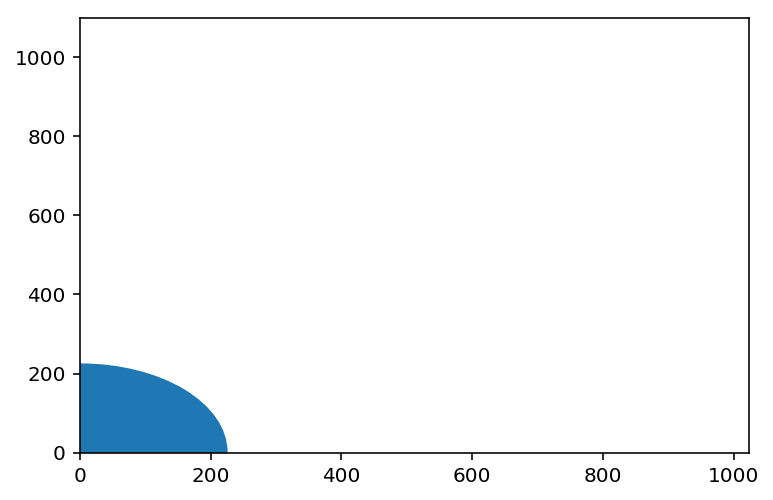

In [89]:
kic_visto_1['kic_kepmag'][kic_visto_1.kic_kepler_id == 12156769]

ra_test = kic_visto_1['kic_degree_ra'][kic_visto_1.kic_kepler_id == 12156769]
dec_test = kic_visto_1['kic_dec'][kic_visto_1.kic_kepler_id == 12156769]
radius_test = 225
apertures = CircularAperture((1061.1056,490.60512), r = radius_test)
phot_table = aperture_photometry(mast, apertures, method = 'exact')
from photutils import CircularAperture as c
c.plot(apertures,(1060,490),fill=True)
plt.xlim(0, 1024) 
plt.ylim(0, 1100)
apertures

In [22]:
phot_table

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,1061.1056,490.60512,1212280.2323001323


In [23]:
dec_test

6393037    50.701839
Name: kic_dec, dtype: float64

In [24]:
flx = phot_table['aperture_sum']

In [25]:
mag = 25.0-2.5*np.log10(flx)
mag

9.790992441195863


In [26]:
print('Getting the photometry on the master frame.')
#apertures to test for optimal apeture size
rads = np.arange(2,5,.25) 

#do the aperture photometry and find the optimal aperture
apertures = [CircularAperture(positions, r=r) for r in rads]
phot_table = aperture_photometry(mast, apertures, method = 'exact')
idx = 0

offset = np.zeros((len(rads),len(x)))
for ii in range(0, len(x)):
    if (x[ii] > 0) and (x[ii] < 1100) and (y[ii] > 0) and (y[ii] < 1024):
        dist = np.sqrt((x[ii]-x)**2+(y[ii]-y)**2)
        chk = np.where(dist < 6.)
        if (len(chk[0]) == 1):
            for jj in range(1, len(rads)):
                mg1 = 25.-2.5*np.log10(phot_table[ii][jj+3])
                mg0 = 25.-2.5*np.log10(phot_table[ii][jj+2])
                offset[jj,ii] = mg1-mg0
prv = 1.
opt_rad = 10.
for ii in range(0, len(rads)):
    chk = np.median(offset[ii,:])        
    if (np.abs(chk-prv) <= 0.001) and (rads[ii] < opt_rad):        
        opt_rad = rads[ii]
        print('The optimal aperture size is '+str(opt_rad)+'.')
    if (np.abs(chk-prv) > 0.001):
        prv = chk

Getting the photometry on the master frame.
The optimal aperture size is 2.25.


In [27]:
kicid = kic_visto_1.kic_kepler_id
kmag = kic_visto_1.kic_kepmag

In [28]:
#do the aperture photometry
apertures = CircularAperture(positions, r = opt_rad)
phot_table = aperture_photometry(mast, apertures, method = 'exact')

#get the background of the image
cimg, clow, chigh = scipy.stats.sigmaclip(mast, low=2.5, high = 2.5) #do a 2.5 sigma clipping
bkg_mean = np.median(cimg) #determine the sky value
sig = np.std(cimg) #determine the sigma(sky)

#convert to magnitudes
flx = phot_table['aperture_sum']-(bkg_mean*(np.pi*opt_rad**2))
flx_er = np.sqrt(phot_table['aperture_sum'])
x_pix = x
y_pix = y

#create the magnitudes from the flux
mag = 25.0-2.5*np.log10(flx)
err = (2.5/np.log(10.))*(flx_er/flx)

In [31]:
#write the magnitudes to a file
output = open(caldir+'_sky_'+str(skygroup)+'_master.ap', 'w')
for ii in range(0, len(phot_table['id'])):
    #if (x_pix[ii] > 0) and (x_pix[ii] < 1100) and (y_pix[ii] > 0) and (y_pix[ii] < 1024) and (np.isnan(mag[ii]) != 1):
    output.write(str(kicid[ii])+','+str(x_pix[ii])+','+str(y_pix[ii])+','+str(kmag[ii])+','+str(mag[ii])+','+str(err[ii])+'\n')
output.close()

#write the fluxes to a file
output = open(caldir+'_sky_'+str(skygroup)+'_master.flux', 'w')
for ii in range(0, len(phot_table['id'])):
    if (x_pix[ii] > 0) and (x_pix[ii] < 1100) and (y_pix[ii] > 0) and (y_pix[ii] < 1024) and (np.isnan(mag[ii]) != 1):
        output.write(str(kicid[ii])+','+str(x_pix[ii])+','+str(y_pix[ii])+','+str(flx[ii])+','+str(flx_er[ii])+'\n')
output.close()

#write the star list to a file
output = open(caldir+'_sky_'+str(skygroup)+'_starlist.txt', 'w')
for ii in range(0, len(phot_table['id'])):
    if (x_pix[ii] > 0) and (x_pix[ii] < 1100) and (y_pix[ii] > 0) and (y_pix[ii] < 1024) and (np.isnan(mag[ii]) != 1):
        output.write(str(kicid[ii])+','+str(x_pix[ii])+','+str(y_pix[ii])+'\n')
output.close()

KeyError: 0